In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import sys
sys.path.append('../')
sys.path.append('../../')

from common import *
from env import *


# The next two functions are common code that make all the trajectory plots. Updating
# them here will update them everywhere
def plot_traj_and_qr(traj, qr, eps, N, n_step=1, ax=None, save_path=None):
    if type(ax) == type(None):
        plt.clf()
        plt.gcf().set_size_inches(8, 3)
        ax = plt.gca()

    qr = np.array(qr)
    qr = np.flip(qr.T, axis=0) + eps
    im = ax.imshow(qr, aspect='auto', vmin=0, vmax=10)

    ticks = np.arange(N) * n_step
    ax.set_yticks(ticks, np.flip(np.arange(N) + 1))
    ax.set_ylabel('N')
    ax.set_xlabel('Steps')
    ax.set_title(fr'$\epsilon = {eps}$')

    plt.colorbar(im, ax=ax)

    adj = -0.425 if n_step == 1 else 2.75
    ax.plot(10 * n_step - np.array(traj)[1:] + adj, color='red')
    ax.set_xlim((0, len(traj) - 1.5))

    plt.gcf().tight_layout()

    if save_path:
        plt.savefig(save_path)
        

def plot_traj_slices(qr, eps, ax=None, n_steps=1):
    qr = np.array(qr) + eps
    if ax == None:
        ax = plt.gca()

    for i in [0, 2, 4, 7, 9]:
        ax.plot(qr[:,i*n_steps + n_steps - 1], label=f'N = {i+1}', alpha=i/15 + 0.35, color='C0')

    ax.set_xlabel('Step')
    ax.set_ylabel(r'Q value')
    ax.legend()

In [2]:
fig_dir = Path('fig')   # directory that will contained saved figures
if not fig_dir.exists():
    fig_dir.mkdir()

# Incremental

In [3]:
eps = np.linspace(-5, 4, num=25)
N = 10

all_lens = []

n_iters = 5

for _ in range(n_iters):
    trajs = [run_exp_inc(eps=e, goal_length=N) for e in eps]
    traj_lens = [len(t) for t, _ in trajs]
    all_lens.append(traj_lens)

all_lens = np.array(all_lens)

Text(0, 0.5, 'Steps')

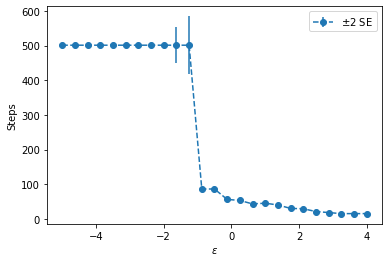

In [4]:
mean = np.mean(all_lens, axis=0)
sd_err = np.std(all_lens, axis=0) / np.sqrt(n_iters)

plt.errorbar(eps, traj_lens, fmt='o--', yerr=sd_err, label=r'$\pm 2$ SE')
plt.legend()

plt.xlabel(r'$\epsilon$')
plt.ylabel('Steps')

# plt.savefig('fig/fig2_inc_failure.png')

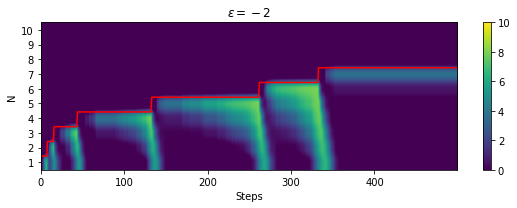

In [5]:
N = 10
eps = -2
traj, info = run_exp_inc(eps=eps, goal_length=N)
plot_traj_and_qr(traj, info['qr'], eps, N, save_path='fig/fig2_failure_qr.png')

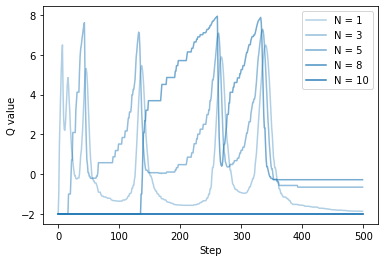

In [6]:
plot_traj_slices(info['qr'], eps)

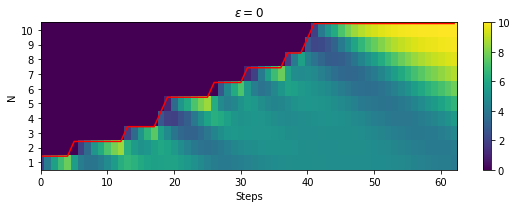

In [7]:
N = 10
eps = 0
traj, info = run_exp_inc(eps=eps, goal_length=N)
plot_traj_and_qr(traj, info['qr'], eps, N, save_path='fig/fig2_middling_qr.png')

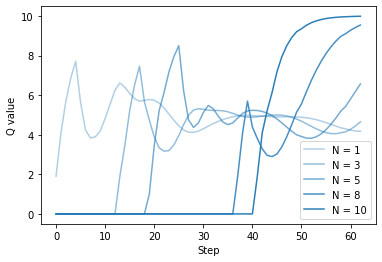

In [8]:
plot_traj_slices(info['qr'], eps)

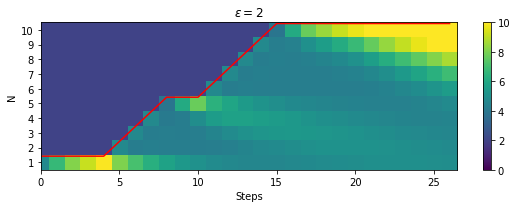

In [9]:
N = 10
eps = 2
traj, info = run_exp_inc(eps=eps, goal_length=N)
plot_traj_and_qr(traj, info['qr'], eps, N, save_path='fig/fig2_success_qr.png')

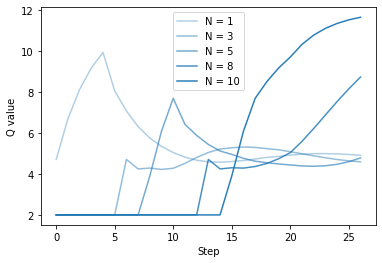

In [10]:
plot_traj_slices(info['qr'], eps)

# POMCP

Download dataframe file (`pomcp.pkl`) on the Google drive: https://drive.google.com/drive/u/1/folders/1yQ0WoPIlG-XdAXXAZLD5-Qz-3NpMtTXg

In [11]:
df = pd.read_pickle('pomcp.pkl')

Individual rows can be plotted much in the same way as above. Below is an example of three different runs:

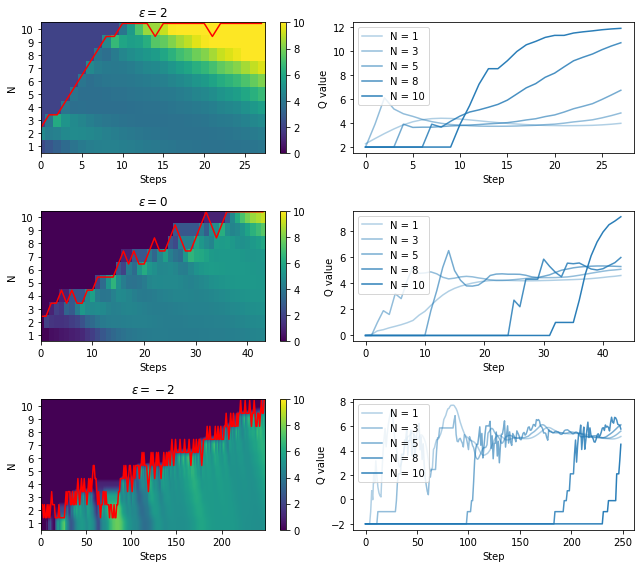

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(9, 8), sharey=False)

N = 10
eps = 2
row = df.loc[14]
traj, info = row['runs'][0], row['info'][0]
plot_traj_and_qr(traj, info['qr'], eps, N, ax=axs[0][0])
plot_traj_slices(info['qr'], ax=axs[0][1], eps=eps)

N = 10
eps = 0
row = df.loc[12]
traj, info = row['runs'][0], row['info'][0]
plot_traj_and_qr(traj, info['qr'], eps, N, ax=axs[1][0])
plot_traj_slices(info['qr'], ax=axs[1,1], eps=eps)

N = 10
eps = -2
row = df.loc[10]
traj, info = row['runs'][0], row['info'][0]
plot_traj_and_qr(traj, info['qr'], eps, N, ax=axs[2,0])
plot_traj_slices(info['qr'], ax=axs[2,1], eps=eps)

fig.tight_layout()

plt.savefig('fig/pomcp_conjoined.png')

# Adaptive

Individual plots can be made much in the same way as before. Below I plot three different examples assembled into a single image.

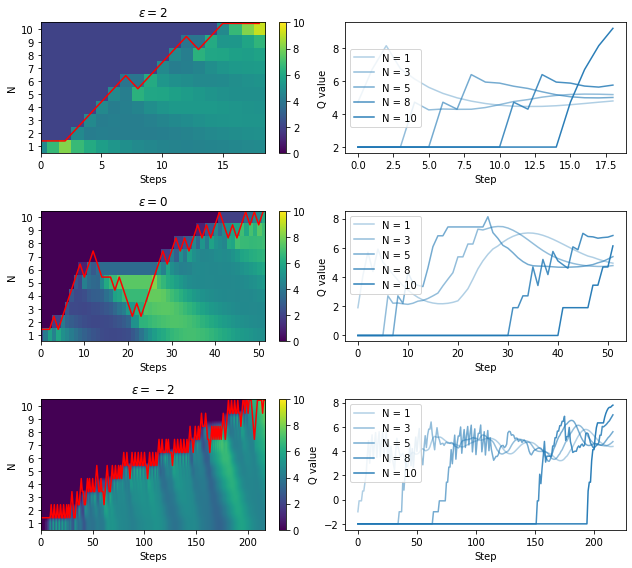

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(9, 8))

N = 10
eps = [2, 0, -2]

for e, ax in zip(eps, axs):
    traj, info = run_adp_exp_disc(eps=e, goal_length=N)
    plot_traj_and_qr(traj, info['qr'], e, N, ax=ax[0])
    plot_traj_slices(info['qr'], e, ax=ax[1])

plt.savefig('fig/adp_conjoined.png')

# Benchmarks

In [14]:
n_iters = 10
Ns = [3, 5, 10]
eps = np.linspace(-2, 2, num=5)
# max_steps = 500

T = 3
lr = 0.1
alpha = 0.1
beta = 1
k = 5

raw_data = []

for N in tqdm(Ns):
    for e in eps:
        cases = [
            Case('Adaptive', run_adp_exp_disc, {'eps': e, 'goal_length': N}, []),
            Case('Incremental', run_exp_inc, {'eps': e, 'goal_length': N}, []),
            Case('Online', run_online, {'eps': e, 'goal_length': N, 'alpha': alpha, 'beta': beta}, []),
            Case('Naive', run_naive, {'eps': e, 'goal_length': N, 'alpha': alpha, 'beta': beta, 'k': k}, []),
            Case('Window', run_window, {'eps': e, 'goal_length': N, 'alpha': alpha, 'beta': beta, 'k': k}, []),
            Case('Sampling', run_sampling, {'eps': e, 'goal_length': N, 'alpha': alpha, 'k': k}, []),
            Case('Random', run_random, {'eps': e, 'goal_length': N}, []),
            Case('Final', run_final_task_only, {'eps': e, 'goal_length': N}, []),
        ]

        run_exp(n_iters=n_iters, cases=cases, max_steps=N * 100, lr=lr, T=T)
        raw_data.extend(cases)

df_bench = pd.DataFrame(raw_data)
df = pd.concat((df, df_bench), ignore_index=True)

  0%|                                                     | 0/3 [00:00<?, ?it/s]/home/grandpaa/workspace/trails/venv_trail/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/grandpaa/workspace/trails/venv_trail/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/grandpaa/workspace/trails/venv_trail/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
100%|█████████████████████████████████████████████| 3/3 [00:23<00:00,  7.80s/it]


In [15]:
# setting up for benchmark plotting
fig_dir = Path('fig/us_v_matiisen_v_pomcp')
if not fig_dir.exists():
    fig_dir.mkdir(parents=True)

def extract_plot_vals(row):
    traj_lens = [len(traj) for traj in row['runs']]

    return pd.Series([
        row['name'],
        row['run_params']['goal_length'],
        np.round(row['run_params']['eps'], decimals=2),
        traj_lens
    ], index=['name', 'N', 'eps', 'traj_lens'])

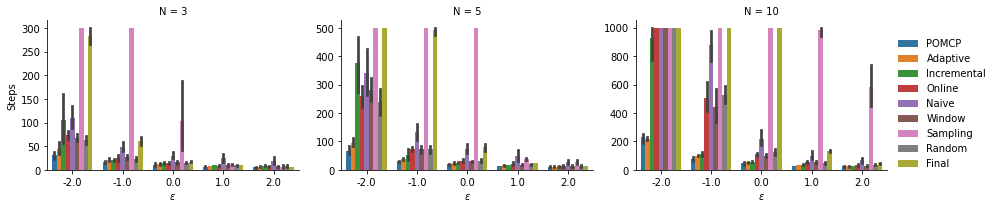

In [16]:
plot_df = df.apply(extract_plot_vals, axis=1).explode('traj_lens')

g = sns.catplot(plot_df, x='eps', y='traj_lens', hue='name', col='N', kind='bar', sharey=False, height=3, aspect=1.4)
g.set_axis_labels(f'$\epsilon$', 'Steps')
g.legend.set_title('')

plt.savefig('fig/us_v_matiisen_v_pomcp/seq_benchmarks_conjoined.png')